# Bio-Argo match-ups
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 21, 2025

We have upwards of 33k bbp700 and 10k chl-a points for the global bio-Argo data. The goal is to get the Rrs data, all bands, for each of these. However, with so many points we need to be careful with memory. Just opening the meta-data for all the Rrs files, 500+ days since March 2024, will eat up a lot of memory.

**What do we do?**

1. When we open the PACE Rrs files, we create `ds` with `chunks{}` so that dask knows the chunk structure.
2. We compute the vector of indices for the Argo points and use `ds.vindex([vector_i, vector_j)`. That will load only the needed chunks.
3. We work through the files in batches and use a dask cluster that we close after finishing with a batch. This will keep the memory from exploding on us as we open files.

**Dask cluster workflow**

1. Create a function to process one file
2. Create a batch for loop that does
    * Grab a batch of file urls (to their location in the cloud)
    * Open a dask cluster
    * Process the files with the process file function
    * Close the cluster when done
    * Grab the next batch of file urls
    * Repeat


## Load the Argo data

In [108]:
# Load data from GitHub
df_y_name="CHLA"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/"
url = f"{base_url}argo_bgc_global_surface_{df_y_name}.parquet"
argo_chl_df = pd.read_parquet(url)

## Get the file urls for the PACE Data

In [106]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
df = argo_chl_df
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.nc"
)
# all days since Mar 2024; pqdm args to quiet output
fileset = earthaccess.open(rrs_results, pqdm_kwargs={"disable": True} );

Check the format of individuals day data.

In [20]:
import xarray as xr
ds = xr.open_dataset(
        fileset[0],
        chunks={}
    )
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (wavelength: 172, lat: 4320, lon: 8640, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3861548
    data_minimum:                      -0.009998
    data_maximum:                      0.092371605

# Workflow to process one file

Assume:

* The files are for a regular grid, i.e. level 3 data
* The files do not have a time coordinate. This is how the PACE level 3 daily and 8-day files are currently structured.
* We are looking at a variable, like Rrs, that has a 3rd dimension of wavelength or similar. Usually called wavelength or wavelength_3d. So the dims are (lat, lon, 3rd dim)
* `time_coverage_start` and `time_coverage_end` exist as attributes in the files.
* `ds[ds_vec_name]` is a 1D coordinate aligned with the last dimension of ds_var_name.

Process Steps:

1.  Subset our Argo dataframe to only those rows within in the  time window covered by the cloud-hosted xarray dataset (`ds`). Let's call that `df_day`
2.  Get the lat/lon indices of `ds` that correspond to the lat/lon rows in `df_day`. These indices will look like `[0, 3, 6]` and `[0, 10, 15]` corresponding to index pairs, like `(3, 10)` corresponding to the lat/lon pair in a row of `df_day`.
3.  Do a fast point retrieval from `ds`. `ds` is cloud optimized (chunked) file and we only want to the chunks that we need. We do not need to load all the chunks. I/O of cloud-hosted data is the slow part so don't touch more of the data than you need to.
4. Build a dataframe with the predictor variables that we want from `ds`.

In [14]:
# New process one file code
import pandas as pd
import earthaccess
import xarray as xr

# specify the ds colnames and variable we want (Rrs)
ds_lat_name="lat"; ds_lon_name="lon"; ds_time_name="time"; ds_vec_name="wavelength"; ds_var_name="Rrs"; 

def process_one_file(record):
    # Make sure we're logged in; earthaccess will refresh token as needed
    earthaccess.login()  # if you're using netrc/env, this is cheap

    # record is a UMM dict from earthdata.search:
    files = earthaccess.open([record], pqdm_kwargs={"disable": True} )   # returns a list of file-like objects
    f = files[0]

    with xr.open_dataset(f, chunks={}, cache=False) as ds:

        # --- Step 1: subset df to the time window in ds
        t_start = pd.to_datetime(ds.attrs["time_coverage_start"], utc=True)
        t_end   = pd.to_datetime(ds.attrs["time_coverage_end"], utc=True)
        df_times = pd.to_datetime(df[df_time_name], utc=True)   
        df_day = df[(df_times >= t_start) & (df_times < t_end)]

        # Stop if no days in df match day in ds
        if df_day.empty: return None

        # --- Step 2: Get an array of Rrs values for the lat/lon in df_day
        # will need index and values later
        lat_idx = ds.get_index(ds_lat_name)
        lon_idx = ds.get_index(ds_lon_name)
        lat_vals = ds[ds_lat_name].values
        lon_vals = ds[ds_lon_name].values
        # Get the lat/lon vals in df_day
        df_lats = df_day[df_lat_name].to_numpy(dtype=float)
        df_lons = df_day[df_lon_name].to_numpy(dtype=float)
        # Use pandas indexer to quickly find indices for vals nearest df
        lat_i = lat_idx.get_indexer(df_lats, method="nearest")
        lon_i = lon_idx.get_indexer(df_lons, method="nearest")

        # Each day has only 10-30 Argo points. This will be faster than .vindex
        def sample_rrs_points(ds, lats, lons, var_name="Rrs"):
            import numpy as np
            R = ds[var_name]  # (lat, lon, wavelength)
            spectra = [
                R.sel(lat=i, lon=j, method="nearest").values
                for i, j in zip(lats, lons)
            ]
            return np.stack(spectra, axis=0)
        
        var_vals=sample_rrs_points(ds, df_lats, df_lons, var_name=ds_var_name)    
        
        # --- Step 4: build a dataframe with our Argo points and PACE data ---
        data = {
            ds_time_name: pd.to_datetime(df_day[df_time_name], utc=True),
            ds_lat_name:  lat_vals[lat_i],
            ds_lon_name:  lon_vals[lon_i],
            "y": df_day[df_y_name].to_numpy(),
            "df_lat": df_lats,
            "df_lon": df_lons
            }

        # Get the wavelength values for our col names
        if not ds_vec_name == None:
            vec_vals = ds[ds_vec_name].values
            for j, v in enumerate(vec_vals):
                label = int(v) # make integer for nicer label
                col_name = f"{ds_var_name}_{label}"
                data[col_name] = var_vals[:, j].astype(float)
        else:
            data[ds_var_name] = var_vals[:].astype(float)

        return pd.DataFrame(data)

In [22]:
%%time
# test that it works
res=process_one_file(results[1])
res.head()

CPU times: user 5.81 s, sys: 2.12 s, total: 7.93 s
Wall time: 27.2 s


,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_706,Rrs_707,Rrs_708,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719
19,2024-03-06 07:12:00+00:00,-68.020836,8.520839,0.453600,-68.040133,8.532055,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2024-03-06 06:23:53.028999936+00:00,-51.520836,89.479172,0.357700,-51.510311,89.460415,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,2024-03-06 21:47:00+00:00,-57.687504,157.062515,0.114950,-57.682947,157.049877,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2024-03-06 12:43:12.000999936+00:00,-53.020836,166.187515,0.569108,-53.022200,166.197400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2024-03-07 01:09:49+00:00,-37.104172,-149.187500,0.103240,-37.091700,-149.182900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Run through the PACE files in batches

Just in case something hangs.

### Create a function to run a batch

* create cluster
* run `process_one_file` using `.map` over all file urls
* gather results (pandas dataframe)
* close cluster and return results

In [23]:
# run_batch function
import pandas as pd
def run_batch(batch_results):
    results = []
    for k, res in enumerate(batch_results, start=1):
        res = process_one_file(res)
        results.append(res)
    return pd.concat(results, ignore_index=True)

In [24]:
%%time
# test that it runs
run_batch(results[0:1])

CPU times: user 3.31 s, sys: 1.11 s, total: 4.42 s
Wall time: 17.5 s


,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_706,Rrs_707,Rrs_708,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719
0,2024-03-05 11:39:00+00:00,-45.770836,136.562515,0.727765,-45.756765,136.574703,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-05 06:58:45.000999936+00:00,-34.145836,-165.729172,0.023080,-34.152200,-165.736500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-03-06 00:25:00+00:00,-31.895838,37.145840,0.018225,-31.877871,37.132439,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-03-06 01:11:24+00:00,-10.687503,49.729172,0.202350,-10.701914,49.728228,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-03-05 08:16:05.000999936+00:00,0.687497,-165.437500,0.514266,0.673300,-165.453300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-03-05 15:35:00+00:00,39.145832,-66.562500,0.317225,39.151501,-66.574600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-03-05 01:16:05+00:00,29.062498,-17.229162,0.881961,29.082600,-17.213600,0.006416,0.0069,0.007244,0.007086,...,0.000218,0.000218,0.000224,0.000214,0.000214,0.000196,0.000174,0.000166,0.00016,0.000214
7,2024-03-05 02:08:10+00:00,25.104164,148.145844,0.036300,25.111515,148.146488,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-03-05 11:37:00+00:00,68.062500,-5.104161,0.036000,68.045173,-5.118235,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-03-05 11:32:39.019000064+00:00,69.687500,4.187506,0.021900,69.673916,4.204859,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## For loop over our batches

* get urls for a batch of 20 PACE files in cloud
* save results to a file in case the process crashes
* later we will reconstruct from the files. The files are small.

## CHLA

In [129]:
%%time
from datetime import datetime

def run_batch(
    results, df, 
    ds_vec_name="wavelength", ds_var_name="Rrs",
    df_time_name="TIME", df_lat_name="LATITUDE", df_lon_name="LONGITUDE"
):
    # Make sure to refresh fileset to minimize the chance that the token expires before we are done
    # this for loop consumes about 6Gb of RAM
    fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );
    
    df_plus = []
    for i, f in enumerate(fileset):
        df_record, pts = mu.one_file_matches(
            f, df, 
            ds_vec_name=ds_vec_name, ds_var_name=ds_var_name,
            df_time_name=df_time_name, df_lat_name=df_lat_name, df_lon_name=df_lon_name)
        if df_record is None or len(df_record) == 0: 
            print(f"Skipped day {i} no data in df")
            continue
        # error check
        if len(df_record) != len(pts):
            raise ValueError(f"Row mismatch: df_record={len(df_record)}, pts={len(pts)}")
    
        # left "concat": keep df_record rows, add pts columns by position
        df_record_plus = pd.concat(
            [ 
                df_record.reset_index(drop=True), 
                pts.reset_index(drop=True),
            ], axis=1,)
        df_plus.append(df_record_plus)
    df_plus = pd.concat(df_plus, ignore_index=True)
    return df_plus

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 9.54 µs


In [107]:
%%time
# test that it works
res=run_batch(rrs_results[0:1], df)
res.head()

CPU times: user 3.33 s, sys: 1.28 s, total: 4.61 s
Wall time: 11.9 s


,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,PRES,TEMP,PSAL,CHLA,pace_Rrs_file,...,pace_Rrs_706,pace_Rrs_707,pace_Rrs_708,pace_Rrs_709,pace_Rrs_711,pace_Rrs_712,pace_Rrs_713,pace_Rrs_714,pace_Rrs_717,pace_Rrs_719
0,5905501,138,2024-03-05 11:39:00.000000000,-45.756765,136.574703,7.600000,12.251000,34.743187,0.727765,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5906304,116,2024-03-05 06:58:45.000999936,-34.152200,-165.736500,10.890000,23.313200,35.541489,0.023080,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4902628,48,2024-03-06 00:25:00.000000000,-31.877871,37.132439,5.725000,24.799250,35.657001,0.018225,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6990505,54,2024-03-06 01:11:24.000000000,-10.701914,49.728228,6.490000,29.196699,34.941002,0.202350,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2903856,19,2024-03-05 08:16:05.000999936,0.673300,-165.453300,10.051112,28.596222,35.037987,0.514266,PACE_OCI.20240305.L3m.DAY.RRS.V3_1.Rrs.4km.nc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "chla"

for batch_idx, i in enumerate(range(0, len(fileset), batch_size), start=1):
    batch = rrs_results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, argo_chl_df)  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")


Batch 1: 10 files: 19:42:58
Skipped day 8 no data in df
  -> Saved 149 rows to data/matchups/chla_matchups_batch_001.parquet
Batch 2: 10 files: 19:45:43
Skipped day 8 no data in df
  -> Saved 152 rows to data/matchups/chla_matchups_batch_002.parquet
Batch 3: 10 files: 19:48:26
Skipped day 0 no data in df
Skipped day 1 no data in df
  -> Saved 144 rows to data/matchups/chla_matchups_batch_003.parquet
Batch 4: 10 files: 19:51:44
  -> Saved 180 rows to data/matchups/chla_matchups_batch_004.parquet
Batch 5: 10 files: 19:55:11
  -> Saved 171 rows to data/matchups/chla_matchups_batch_005.parquet
Batch 6: 10 files: 19:58:49
  -> Saved 161 rows to data/matchups/chla_matchups_batch_006.parquet
Batch 7: 10 files: 20:02:37
  -> Saved 172 rows to data/matchups/chla_matchups_batch_007.parquet
Batch 8: 10 files: 20:06:02
  -> Saved 157 rows to data/matchups/chla_matchups_batch_008.parquet
Batch 9: 10 files: 20:09:14
  -> Saved 156 rows to data/matchups/chla_matchups_batch_009.parquet
Batch 10: 10 fi

In [118]:
# When everything is done, you can merge all batches:
batch_files = sorted(results_dir.glob(f"{var}_matchups_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"tutorial_data/{var}_argo_rss_all.parquet", index=False)
rrs_cols = [c for c in df_all.columns if c.startswith("pace_Rrs_") and c[-1].isdigit()]
df_all_clean = df_all.dropna(subset=rrs_cols, how="all").reset_index(drop=True)
df_all_clean.to_parquet(f"tutorial_data/{var}_argo_rss.parquet", index=False)


In [119]:
print(f"Total rows: {len(df_all_clean)}")
print(f"Total rows: {len(df_all)}")

Total rows: 2271
Total rows: 12140


### Same idea. Add on the PACE CHLA data

I just add to the cleaned data since if no Rrs then no CHL either.

In [127]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

In [125]:
# Add on chla to the clean parquet
import pandas as pd
import earthaccess
import xarray as xr

# Load data from GitHub
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/"
url = f"{base_url}chla_argo_rss.parquet"
chla_argo_rss_df = pd.read_parquet(url)

chla_argo_rss_df = df_all_clean
print(f"{len(chla_argo_rss_df)} rows in dataframe")


# Get PACE CHL data
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)
import xarray as xr
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (df.TIME.min(), df.TIME.max()),
    granule_name="*.DAY.*.4km.nc"
)
print(f"{len(chl_results)} days of PACE data")

2271 rows in dataframe
560 days of PACE data


In [131]:
from pathlib import Path
from datetime import datetime
import pandas as pd

results_dir = Path("data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "chla"

for batch_idx, i in enumerate(range(0, len(fileset), batch_size), start=1):
    batch = chl_results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files: {datetime.now():%H:%M:%S}")

    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_rss_chl_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    df_batch = run_batch(batch, chla_argo_rss_df, ds_vec_name=None, ds_var_name="chlor_a")  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")

Batch 1: 50 files: 00:23:48
Skipped day 8 no data in df
Skipped day 18 no data in df
Skipped day 19 no data in df
Skipped day 20 no data in df
Skipped day 21 no data in df
  -> Saved 206 rows to data/matchups/chla_matchups_rss_chl_batch_001.parquet
Batch 2: 50 files: 00:24:05
Skipped day 9 no data in df
Skipped day 26 no data in df
Skipped day 40 no data in df
  -> Saved 174 rows to data/matchups/chla_matchups_rss_chl_batch_002.parquet
Batch 3: 50 files: 00:24:23
  -> Saved 193 rows to data/matchups/chla_matchups_rss_chl_batch_003.parquet
Batch 4: 50 files: 00:24:39
Skipped day 28 no data in df
Skipped day 29 no data in df
  -> Saved 216 rows to data/matchups/chla_matchups_rss_chl_batch_004.parquet
Batch 5: 50 files: 00:24:57
Skipped day 14 no data in df
Skipped day 15 no data in df
Skipped day 19 no data in df
  -> Saved 192 rows to data/matchups/chla_matchups_rss_chl_batch_005.parquet
Batch 6: 50 files: 00:25:15
  -> Saved 248 rows to data/matchups/chla_matchups_rss_chl_batch_006.par

In [132]:
# When everything is done, you can merge all batches:
batch_files = sorted(results_dir.glob(f"{var}_matchups_rss_chl_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"tutorial_data/{var}_argo_rss_chla.parquet", index=False)

In [ ]:
a = df_all[df_all["pace_chlor_a_file"].duplicated(keep=False) == False]
a[["pace_Rrs_t_end", "pace_chlor_a_t_end"]]

In [3]:
import pandas as pd
df=pd.read_parquet("tutorial_data/chla_argo_rss_chl.parquet")
df.columns

Index(['time', 'lat', 'lon', 'y', 'df_lat', 'df_lon', 'Rrs_346', 'Rrs_348',
       'Rrs_351', 'Rrs_353',
       ...
       'Rrs_707', 'Rrs_708', 'Rrs_709', 'Rrs_711', 'Rrs_712', 'Rrs_713',
       'Rrs_714', 'Rrs_717', 'Rrs_719', 'pace_chlor_a'],
      dtype='object', length=179)

In [6]:
df_clean = df.dropna().reset_index(drop=True)
len(df_clean)

2341

Bias (log10, PACE - Argo) by *local solar hour*:


,mean,median,std,count
solar_hour_bin,,,,
0,0.103853,0.151630,0.333050,79
1,0.144646,0.179892,0.391197,80
2,0.060992,0.074607,0.330897,86
3,0.052422,0.156559,0.396907,64
4,0.153144,0.101886,0.370502,76
5,0.152962,0.140504,0.375917,70
6,0.181948,0.118895,0.586215,72
7,0.196871,0.179550,0.363487,81
8,0.124520,0.063100,0.372006,68


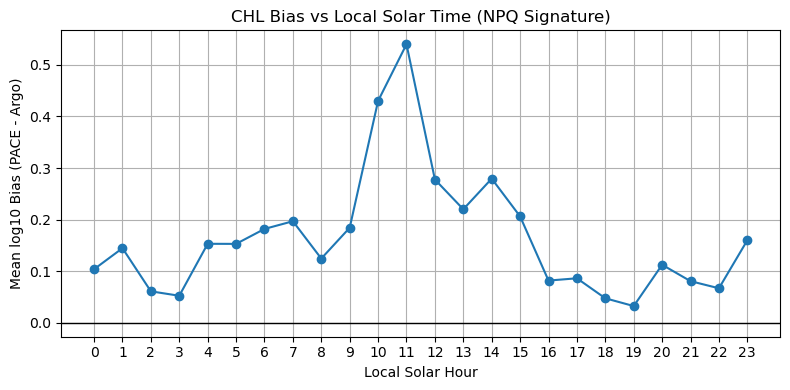

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
#  CHL bias vs local solar time
# ============================

df_bias = df.copy()

# --- Ensure datetime ---
df_bias['time'] = pd.to_datetime(df_bias['time'], utc=True, errors='coerce')

# --- Basic cleaning: drop rows missing key fields ---
df_bias = df_bias.dropna(subset=['time', 'lon', 'y', 'pace_chlor_a'])

# --- Remove non-positive CHL (can't take log10 of these) ---
df_bias = df_bias[(df_bias['y'] > 0) & (df_bias['pace_chlor_a'] > 0)]

# --- Compute log10 CHL and bias (PACE - Argo) ---
eps = 1e-6  # tiny offset for numerical safety, but we already filtered <=0
df_bias['log_y'] = np.log10(df_bias['y'] + eps)
df_bias['log_chl_sat'] = np.log10(df_bias['pace_chlor_a'] + eps)
df_bias['bias'] = df_bias['log_chl_sat'] - df_bias['log_y']

# --- Compute local solar time (approx) ---
# longitude in degrees east; 15° = 1 hour offset from UTC
df_bias['solar_hour'] = (df_bias['time'].dt.hour + df_bias['lon'] / 15.0) % 24

# Bin into integer solar hours (0–23)
df_bias['solar_hour_bin'] = df_bias['solar_hour'].astype(int)

# --- Group by local solar hour and compute stats ---
bias_by_solar = df_bias.groupby('solar_hour_bin')['bias'].agg(['mean', 'median', 'std', 'count'])

print("Bias (log10, PACE - Argo) by *local solar hour*:")
display(bias_by_solar)

# --- Plot mean bias vs local solar hour ---
plt.figure(figsize=(8, 4))
plt.plot(bias_by_solar.index, bias_by_solar['mean'], '-o')
plt.axhline(0, color='k', lw=1)
plt.xlabel('Local Solar Hour')
plt.ylabel('Mean log10 Bias (PACE - Argo)')
plt.title('CHL Bias vs Local Solar Time (NPQ Signature)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()




In [16]:
np.mean(df["bias"])

np.float64(0.2059161164502753)

/tmp/ipykernel_11146/3715178961.py:9: RuntimeWarning: divide by zero encountered in log
  y_true = np.log(y_true_raw)
/tmp/ipykernel_11146/3715178961.py:9: RuntimeWarning: invalid value encountered in log
  y_true = np.log(y_true_raw)


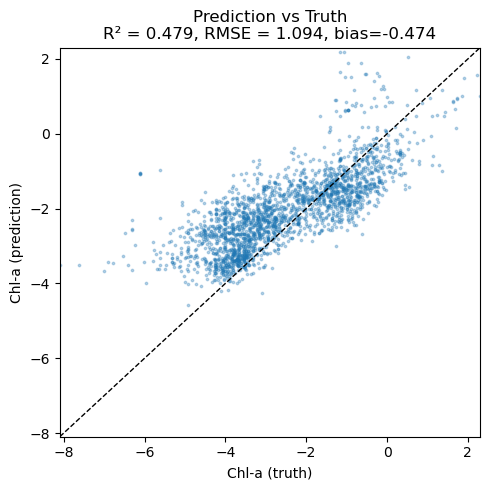

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Take logs (natural log; use np.log10 if you prefer log10)
y_true_raw = df_clean["y"].values
y_pred_raw = df_clean["pace_chlor_a"].values

y_true = np.log(y_true_raw)
y_pred = np.log(y_pred_raw)

# Mask: positive & finite in both
mask = (
    np.isfinite(y_true) &
    np.isfinite(y_pred) &
    (y_true_raw > 0) &
    (y_pred_raw > 0)
)

y_true = y_true[mask]
y_pred = y_pred[mask]

# Compute some metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
bias = np.mean(y_true-y_pred)

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Chl-a (truth)")
plt.ylabel("Chl-a (prediction)")
plt.title(f"Prediction vs Truth\nR² = {r2:.3f}, RMSE = {rmse:.3f}, bias={bias:.3f}")
plt.tight_layout()
plt.show()

In [86]:
for i, f in enumerate(fileset[0:3]):
    df_record, pts = mu.one_file_matches(f, df, ds_vec_name=None, ds_var_name="chlor_a")
df_record

,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_706,Rrs_707,Rrs_708,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719
3,2024-03-07 14:17:38.002000128+00:00,-58.729172,136.020844,0.280511,-58.739200,136.018600,0.012482,0.012338,0.012580,0.012652,...,0.000232,0.000226,0.000220,0.000210,0.000204,0.000194,0.000204,0.000212,0.000146,0.000020
4,2024-03-07 18:01:17.002000128+00:00,17.645832,-46.020828,0.009105,17.666500,-46.015500,0.014870,0.015156,0.015466,0.015632,...,0.000214,0.000202,0.000194,0.000190,0.000184,0.000178,0.000178,0.000174,0.000186,0.000192
5,2024-03-07 12:53:45.049999872+00:00,11.562498,-24.770828,0.047450,11.545350,-24.760472,0.005636,0.006030,0.006400,0.006598,...,0.000238,0.000222,0.000216,0.000208,0.000204,0.000200,0.000196,0.000180,0.000136,0.000138
6,2024-03-07 02:07:40+00:00,25.020832,148.104172,-0.004033,25.023887,148.098503,0.011946,0.012350,0.012650,0.012968,...,0.000182,0.000174,0.000162,0.000160,0.000156,0.000154,0.000150,0.000144,0.000158,0.000194
7,2024-03-07 12:47:51.996000+00:00,55.187500,14.520839,0.389745,55.206148,14.537791,0.004868,0.004760,0.004686,0.004264,...,0.000300,0.000298,0.000294,0.000286,0.000276,0.000272,0.000274,0.000272,0.000174,0.000044
11,2024-03-08 01:17:47.019000064+00:00,-5.520836,71.770844,0.039600,-5.537387,71.762051,0.011868,0.012016,0.012344,0.012436,...,0.000104,0.000088,0.000076,0.000070,0.000054,0.000054,0.000058,0.000068,0.000166,0.000226


In [11]:
var = "chla"
df_plus.to_parquet(f"tutorial_data/{var}_argo_rss_chl.parquet", index=False)

In [36]:
df_test = pd.read_parquet(f"tutorial_data/{var}_argo_rss_chl.parquet")

In [55]:
# How many duplicated times?
print(len(df)-len(df_test))
dup_mask = df_test[["time", "lat", "lon", "y", "df_lat", "df_lon"]].duplicated(keep=False)  # marks *all* rows with duplicated time
print("Number of rows with duplicated time:", dup_mask.sum())



-299
Number of rows with duplicated time: 598


In [56]:
df_dups = df_test[dup_mask].sort_values("time")
df_dups.head(20)

,time,lat,lon,y,df_lat,df_lon,Rrs_346,Rrs_348,Rrs_351,Rrs_353,...,Rrs_707,Rrs_708,Rrs_709,Rrs_711,Rrs_712,Rrs_713,Rrs_714,Rrs_717,Rrs_719,pace_chlor_a
3,2024-03-07 02:07:40+00:00,25.020832,148.104172,-0.004033,25.023887,148.098503,0.011946,0.012350,0.012650,0.012968,...,0.000174,0.000162,0.000160,0.000156,0.000154,0.000150,0.000144,0.000158,0.000194,NaN
7,2024-03-07 02:07:40+00:00,25.020832,148.104172,-0.004033,25.023887,148.098503,0.011946,0.012350,0.012650,0.012968,...,0.000174,0.000162,0.000160,0.000156,0.000154,0.000150,0.000144,0.000158,0.000194,0.053397
9,2024-03-08 01:17:47.019000064+00:00,-5.520836,71.770844,0.039600,-5.537387,71.762051,0.011868,0.012016,0.012344,0.012436,...,0.000088,0.000076,0.000070,0.000054,0.000054,0.000058,0.000068,0.000166,0.000226,NaN
13,2024-03-08 01:17:47.019000064+00:00,-5.520836,71.770844,0.039600,-5.537387,71.762051,0.011868,0.012016,0.012344,0.012436,...,0.000088,0.000076,0.000070,0.000054,0.000054,0.000058,0.000068,0.000166,0.000226,0.103161
14,2024-03-09 01:00:45+00:00,5.937498,66.104172,0.026579,5.931900,66.120400,0.005772,0.006102,0.006410,0.006506,...,0.000166,0.000156,0.000146,0.000140,0.000136,0.000130,0.000128,0.000128,0.000142,0.152522
16,2024-03-09 01:00:45+00:00,5.937498,66.104172,0.026579,5.931900,66.120400,0.005772,0.006102,0.006410,0.006506,...,0.000166,0.000156,0.000146,0.000140,0.000136,0.000130,0.000128,0.000128,0.000142,NaN
15,2024-03-09 02:06:54+00:00,24.895832,148.145844,-0.009939,24.915095,148.155258,0.010484,0.011170,0.011522,0.011348,...,0.000152,0.000158,0.000148,0.000136,0.000132,0.000124,0.000134,0.000214,0.000230,NaN
18,2024-03-09 02:06:54+00:00,24.895832,148.145844,-0.009939,24.915095,148.155258,0.010484,0.011170,0.011522,0.011348,...,0.000152,0.000158,0.000148,0.000136,0.000132,0.000124,0.000134,0.000214,0.000230,0.065469
19,2024-03-11 00:31:42.020999936+00:00,-2.020836,56.020840,0.034000,-2.029857,56.009033,0.017232,0.017342,0.017406,0.017408,...,0.000084,0.000080,0.000080,0.000074,0.000084,0.000064,0.000024,0.000000,0.000096,0.063485
22,2024-03-11 00:31:42.020999936+00:00,-2.020836,56.020840,0.034000,-2.029857,56.009033,0.017232,0.017342,0.017406,0.017408,...,0.000084,0.000080,0.000080,0.000074,0.000084,0.000064,0.000024,0.000000,0.000096,NaN


In [64]:
%%time
from datetime import datetime

# Make sure to refresh fileset to minimize the chance that the token expires before we are done
# this for loop consumes about 6Gb of RAM
fileset = earthaccess.open(results, pqdm_kwargs={"disable": True} );

df_plus = []
for i, f in enumerate(fileset):
    a, b, c = test(f, df, ds_vec_name=None, ds_var_name="chlor_a")
    print(f"{a} to {b}")


2024-03-05 00:08:58.225000+00:00 to 2024-03-06 02:07:24.895000+00:00
2024-03-06 00:29:05.158000+00:00 to 2024-03-07 02:32:31.886000+00:00
2024-03-06 23:40:51.123000+00:00 to 2024-03-08 01:44:18.027000+00:00
2024-03-08 00:10:58.172000+00:00 to 2024-03-09 02:09:25.018000+00:00
2024-03-09 00:36:04.111000+00:00 to 2024-03-10 01:21:10.983000+00:00
2024-03-10 00:56:11.220000+00:00 to 2024-03-11 01:46:19.905000+00:00
2024-03-11 00:12:59.173000+00:00 to 2024-03-12 02:11:26.019000+00:00
2024-03-12 00:38:06.165000+00:00 to 2024-03-12 14:12:57.545000+00:00
2024-03-15 20:10:13.526000+00:00 to 2024-03-16 01:30:10.043000+00:00
2024-03-15 23:56:50.189000+00:00 to 2024-03-17 02:00:16.039000+00:00
2024-03-17 00:21:56.126000+00:00 to 2024-03-18 02:30:22.034000+00:00
2024-03-17 23:33:41.213000+00:00 to 2024-03-19 01:37:06.887000+00:00
2024-03-19 00:03:47.208000+00:00 to 2024-03-20 02:02:12.001000+00:00
2024-03-20 00:28:52.147000+00:00 to 2024-03-21 01:18:56.970000+00:00
2024-03-20 23:40:37.058000+00:00 t

KeyboardInterrupt: 

## BBP700

In [25]:
# BBP700
# Load data from GitHub
df_y_name="BBP700"; df_lat_name="LATITUDE"; df_lon_name="LONGITUDE"; df_time_name="TIME"
import pandas as pd
base_url="https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/"
url = f"{base_url}argo_bgc_global_surface_{df_y_name}.parquet"
df = pd.read_parquet(url)

In [26]:
# BBP700
from pathlib import Path
import pandas as pd

results_dir = Path("data/matchups")
results_dir.mkdir(exist_ok=True)

all_batches = []
batch_size = 10
var = "bbp700"

for batch_idx, i in enumerate(range(0, len(results), batch_size), start=1):
    # If this batch was already done, skip it
    batch_path = results_dir / f"{var}_matchups_batch_{batch_idx:03d}.parquet"
    if batch_path.exists():
        print(f"  -> Skipping batch {batch_idx}, found {batch_path}")
        continue

    batch = results[i:i+batch_size]
    print(f"Batch {batch_idx}: {len(batch)} files")
        
    df_batch = run_batch(batch)  # returns a DataFrame

    # Save this batch immediately
    df_batch.to_parquet(batch_path, index=False)
    print(f"  -> Saved {len(df_batch)} rows to {batch_path}")


  -> Skipping batch 1, found data/matchups/bbp700_matchups_batch_001.parquet
  -> Skipping batch 2, found data/matchups/bbp700_matchups_batch_002.parquet
  -> Skipping batch 3, found data/matchups/bbp700_matchups_batch_003.parquet
  -> Skipping batch 4, found data/matchups/bbp700_matchups_batch_004.parquet
  -> Skipping batch 5, found data/matchups/bbp700_matchups_batch_005.parquet
  -> Skipping batch 6, found data/matchups/bbp700_matchups_batch_006.parquet
  -> Skipping batch 7, found data/matchups/bbp700_matchups_batch_007.parquet
  -> Skipping batch 8, found data/matchups/bbp700_matchups_batch_008.parquet
  -> Skipping batch 9, found data/matchups/bbp700_matchups_batch_009.parquet
  -> Skipping batch 10, found data/matchups/bbp700_matchups_batch_010.parquet
  -> Skipping batch 11, found data/matchups/bbp700_matchups_batch_011.parquet
  -> Skipping batch 12, found data/matchups/bbp700_matchups_batch_012.parquet
  -> Skipping batch 13, found data/matchups/bbp700_matchups_batch_013.par

In [ ]:
# When everything is done, you can merge all batches:
from pathlib import Path
import pandas as pd

var = "bbp700"
results_dir = Path("data/matchups")

batch_files = sorted(results_dir.glob(f"{var}_matchups_batch_*.parquet"))
dfs = [pd.read_parquet(f) for f in batch_files]
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(f"tutorial_data/{var}_argo_rss_all.parquet", index=False)
rrs_cols = [c for c in df_all.columns if c.startswith("Rrs_")]
df_all_clean = df_all.dropna(subset=rrs_cols, how="all").reset_index(drop=True)
df_all_clean.to_parquet(f"tutorial_data/{var}_argo_rss.parquet", index=False)

In [5]:
print(f"Total rows: {len(df_all_clean)}")
print(f"Total rows: {len(df_all)}")


Total rows: 5599
Total rows: 29950


---------------------
## Testing stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

y_true = df_plus.y

# Compute some metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Chl-a (truth)")
plt.ylabel("Chl-a (prediction)")
plt.title(f"Prediction vs Truth\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.tight_layout()
plt.show()

In [67]:
type(fileset[0])

earthaccess.store.EarthAccessFile

In [62]:
# process one file code
import pandas as pd
import earthaccess
import xarray as xr

def test(
    f, df,
    ds_lat_name="lat", ds_lon_name="lon", ds_time_name="time", 
    ds_vec_name="wavelength", ds_var_name="Rrs",
    df_lat_name="lat", df_lon_name="lon", df_time_name="time",
    df_var_name="y"
):
    with xr.open_dataset(f, chunks={}, cache=False) as ds:

        # --- Step 1: subset df to the time window in ds
        t_start = pd.to_datetime(ds.attrs["time_coverage_start"], utc=True)
        t_end   = pd.to_datetime(ds.attrs["time_coverage_end"], utc=True)
        df_times = pd.to_datetime(df[df_time_name], utc=True)
        # df points that are in this record
        df_record = df[(df_times >= t_start) & (df_times < t_end)]
        return t_start, t_end, df_record[df_time_name]
